In [1]:

import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import math # to help with data reshaping of the data

import numpy as np
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt
import logging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.chdir('../')

from pose_gru import PoseGRU_inputFC2
from benji_prox_dataloader import *

numpy: 1.21.5


In [5]:
root_dir = 'D:/prox_data/PROXD_attempt2/PROXD'
smplx_model_path='../models_smplx_v1_1/models/'
in_frames = 10
pred_frames = 5
batch_size = 15
pd = proxDataset(root_dir, in_frames=in_frames, pred_frames=pred_frames, output_type='joint_locations', smplx_model_path=smplx_model_path)


dataloader = DataLoader(pd, batch_size=batch_size,
                        shuffle=True, num_workers=0, collate_fn=my_collate)

In [7]:
a, b, c = pd.__getitem__(3)

In [8]:
a

3

In [10]:
b.shape

torch.Size([10, 127, 3])

In [11]:
c.shape

torch.Size([5, 127, 3])

In [ ]:
criterion = nn.MSELoss()
learning_rate=0.0001
losses = []
losses_rep = []

# rnn = MockupModel(input_size=21*3, hidden_size=50, num_layers=2, output_size=(pred_frames, 21, 3), seq_len=in_frames)
gru = PoseGRU_inputFC2(input_size=(127,3))

optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

n_iter = 3
i = 0
for epoch in range(n_iter):
    for i, (indices, in_skels, fut_skels) in (pbar := tqdm.tqdm(enumerate(dataloader))):
        optimizer.zero_grad()
        
        cur_state, pred_skels = gru.forward_prediction(in_skels, pred_len=pred_frames)
        loss = criterion(pred_skels, fut_skels)
        loss.backward()
        optimizer.step() 

        rep_pred = in_skels[:, -1, :, :]
        rep_pred = rep_pred.tile(pred_frames, 1, 1, 1).transpose(0, 1)
        loss_rep = criterion(rep_pred, fut_skels)
        losses_rep.append(loss_rep)

#         for p in gru.parameters():
#             _ = p.data.add_(p.grad.data, alpha=-learning_rate)

        
    
        losses.append(loss.item())
        # print(i, loss)
        pbar.set_description(f"avg last 20 loss: {np.mean(losses[-20:]):.4f} avg last 200-100: {np.mean(losses[-200:-100]):.4f}")

    print(f'end epoch {epoch}: total mean loss: {np.mean(losses)}')

plt.plot(losses)
print(losses[-4:])

0it [00:00, ?it/s]C:\Users\benja\Anaconda3\envs\torch3d\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\benja\Anaconda3\envs\torch3d\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
avg last 20 loss: 0.0022 avg last 200-100: nan: : 87it [32:08, 40.05s/it]

In [1]:
losses

NameError: name 'losses' is not defined

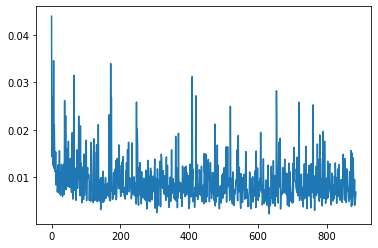

In [14]:
plt.plot(losses)

In [14]:
from scipy.ndimage import gaussian_filter

In [23]:
losses_rep[0].item()

0.0013334888499230146

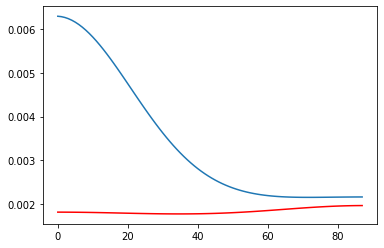

In [26]:
plt.plot(gaussian_filter(losses, sigma=20))
plt.plot(gaussian_filter([l.item() for l in losses_rep], sigma=20), color='red')

In [ ]:
from pytorch3d import transforms

In [37]:
losses_extrapolated0 = []
losses_extrapolated1 = []
for i, (indices, in_skels, fut_skels) in (pbar := tqdm.tqdm(enumerate(dataloader))):
    grad = in_skels[:, -1, :, :] - in_skels[:, -2, :, :]
    rep_pred = in_skels[:, -1, :, :]
    rep_pred2 = rep_pred.tile(pred_frames, 1, 1, 1).transpose(0, 1)
    rep_pred3 = rep_pred2 + torch.arange(1, pred_frames+1).float().reshape(1, -1, 1, 1) * grad.tile(pred_frames, 1, 1, 1).transpose(0, 1)

    losses_extrapolated0.append(criterion(rep_pred2, fut_skels))
    losses_extrapolated1.append(criterion(rep_pred3, fut_skels))

315it [09:44,  1.86s/it]


KeyboardInterrupt: 

In [38]:
np.mean(losses_extrapolated0)
np.mean(losses_extrapolated1)

0.009032417

0.060577102

In [36]:
np.mean(losses_extrapolated0)
np.mean(losses_extrapolated1)

0.00875395

0.040177908

In [28]:
torch.range(0, 4)

<ipython-input-28-398d331f5fab>:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(0, 4)


tensor([0., 1., 2., 3., 4.])

In [22]:
grad = in_skels[:, -1, :, :] - in_skels[:, -2, :, :]
grad.shape
grad.unsqueeze(0).transpose(0, 1).shape
rep_pred = in_skels[:, -1, :, :]
rep_pred2 = rep_pred.tile(pred_frames, 1, 1, 1).transpose(0, 1)
rep_pred2.shape
rep_pred3 = rep_pred2 + torch.tensor([0., 1., 2., 3., 4.]).reshape(1, -1, 1, 1) * grad.tile(pred_frames, 1, 1, 1).transpose(0, 1)

torch.Size([15, 21, 3])

torch.Size([15, 1, 21, 3])

torch.Size([15, 5, 21, 3])

torch.Size([15, 5, 21, 3])

In [26]:
rep_pred3[0, 0, :3]
rep_pred2[0, 0, :3]

rep_pred3[0, 3, :3]
rep_pred2[0, 3, :3]

tensor([[-1.1810, -0.2070,  0.7226],
        [-0.6268, -0.2321, -0.7042],
        [ 0.9639,  0.1113, -0.0624]])

tensor([[-1.1810, -0.2070,  0.7226],
        [-0.6268, -0.2321, -0.7042],
        [ 0.9639,  0.1113, -0.0624]])

tensor([[-1.0710, -0.1575,  0.7301],
        [-0.5583, -0.3148, -0.7431],
        [ 0.8976,  0.1305, -0.0554]])

tensor([[-1.1810, -0.2070,  0.7226],
        [-0.6268, -0.2321, -0.7042],
        [ 0.9639,  0.1113, -0.0624]])

In [11]:
from scipy.ndimage import gaussian_filter

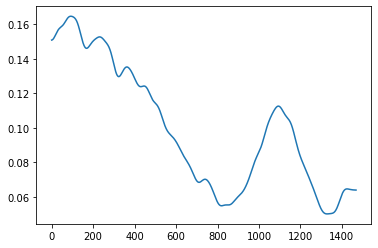

In [12]:
plt.plot(gaussian_filter(losses, sigma=20))

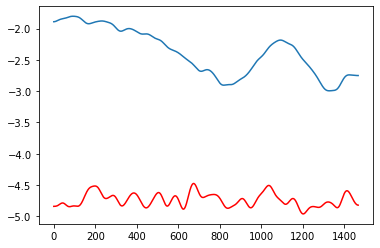

In [13]:
plt.plot(np.log(gaussian_filter(losses, sigma=20)))
plt.plot(np.log(gaussian_filter(losses_rep, sigma=20)), color='red')

In [55]:
torch.min(in_skels)
torch.max(in_skels)
torch.min(pred_skels)
torch.max(pred_skels)

tensor(-1.0774)

tensor(1.2864)

tensor(-1.2333)

tensor(1.4083)

In [14]:
in_skels.shape
in_skels[0, -2, :6]
in_skels[0, -1, :6]
pred_skels[0, 0, :6]

torch.Size([4, 10, 21, 3])

tensor([[-0.3179, -0.1304, -0.0090],
        [-0.3812,  0.0191, -0.0526],
        [ 0.2820, -0.0099,  0.0138],
        [ 0.1667, -0.0873,  0.0161],
        [ 1.2000, -0.1086,  0.0210],
        [-0.1702, -0.0049,  0.0140]])

tensor([[-0.3633, -0.1326,  0.0189],
        [-0.4161,  0.0095, -0.0526],
        [ 0.2898, -0.0135,  0.0326],
        [ 0.3231, -0.0691, -0.0657],
        [ 1.2414, -0.0815,  0.1173],
        [-0.2037, -0.0064,  0.0075]])

tensor([[-0.2784,  0.0358,  0.0542],
        [-0.3149, -0.0151, -0.0153],
        [ 0.2918,  0.1655,  0.1089],
        [ 0.3239,  0.0657, -0.0652],
        [ 0.4129, -0.0502,  0.0414],
        [-0.0822, -0.1353, -0.0549]], grad_fn=<SliceBackward0>)

In [60]:
in_skels.shape
in_skels[0, -2, :6]
in_skels[0, -1, :6]
pred_skels[0, 0, :6]

torch.Size([4, 10, 21, 3])

tensor([[ 0.3130,  0.0455, -0.0652],
        [-0.5712,  0.0728,  0.0162],
        [ 0.2158, -0.1059, -0.0386],
        [-0.0323, -0.1706,  0.0347],
        [ 0.4868, -0.0944, -0.0178],
        [-0.0655, -0.0543,  0.0548]])

tensor([[ 0.3192,  0.0343, -0.0728],
        [-0.5910,  0.0802,  0.0175],
        [ 0.2021, -0.1082, -0.0371],
        [ 0.0180, -0.1868,  0.0386],
        [ 0.5461, -0.0984, -0.0153],
        [-0.0772, -0.0501,  0.0588]])

tensor([[ 0.3029,  0.0263, -0.0564],
        [-0.6359,  0.0879,  0.0205],
        [ 0.2078, -0.1110, -0.0400],
        [ 0.0894, -0.1865,  0.0362],
        [ 0.6398, -0.0971, -0.0101],
        [-0.0926, -0.0507,  0.0598]])

In [50]:
xin = df2.MedTemp[:7].array
def predict(xin):
    # hidden = rnn.initHidden()
    out = rnn(torch.tensor(xin).float().reshape(1, -1))
    yout = out.detach().numpy()
    return yout




<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

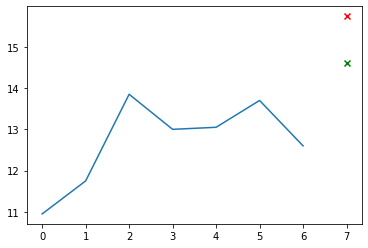

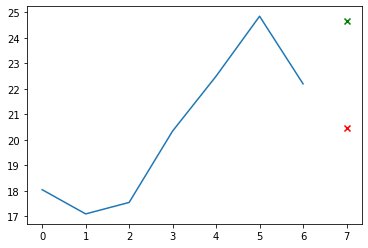

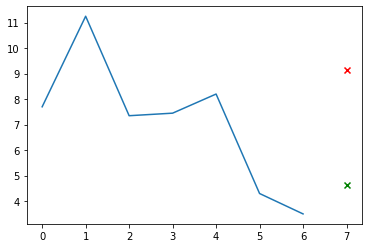

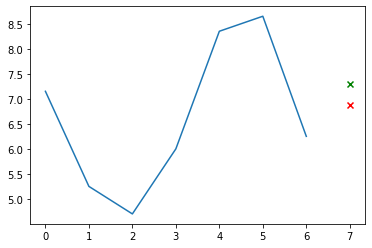

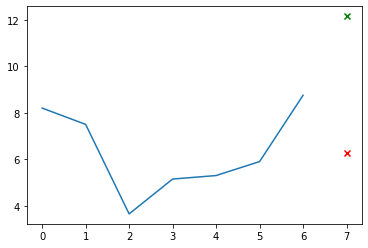

In [51]:
def plot(xin, ypred, ytrue):
    plt.plot(xin)
    plt.scatter(len(xin), ypred, color='r', marker='x')
    plt.scatter(len(xin), ytrue, color='g', marker='x')


for i in range(10, 15):
    xin = X_test[i]
    ypred = predict(xin)
    ytrue = Y_test[i]
    plt.figure()
    plot(xin, ypred, ytrue)


In [50]:
xin

<PandasArray>
[             16.15,              20.45, 18.549999999999997,
               14.4, 11.850000000000001, 11.549999999999999,
 12.149999999999999]
Length: 7, dtype: float64

In [ ]:
3